## Description

In this example a recurrent network (reservoir network) is build. The activity in the network is started by an input. Since the network is in a relative stable state, the activity goes on after the input, whithout any further input (or noise or bias): spontaneous activity.

Two snips are used. The first snip just initializes some parameters, the second snip stops/resets the activity in the network. The currents and voltages are set to zero for some timesteps in a row. After that, in a short period nothing happens, before exactly the same input starts again. This happens three times (3 trials).

Therefore, the structure of one trial is as follows:

1. Resetting the voltages/currents (10 timesteps)
2. Wait some time doing nothing (10 timesteps)
3. Give input (20 timesteps)
4. Do nothing, but this time the network should spike spontaneously (80 timesteps)

### What should happen?

Since the input is exactly the same in every trial, the network should perform the same spiking pattern every time.

### What happens?

In the first trial, everythings seems to work. In the upcoming trials, the network behaves different.

Especially the voltages are increasing stepwise in phase 2, where nothin should happen.


In [1]:
# official
import os
import numpy as np
from scipy import sparse
import itertools

# nxsdk
import nxsdk.api.n2a as nx
from nxsdk.graph.processes.phase_enums import Phase

In [2]:
# Create nxnet object
nxNet = nx.NxNet()

In [3]:
"""
Parameters
"""

# Experiment
nTrials = 3  # number of trials

# Network
nEx = 400  # number of excitatory neurons
nIn = int(400/4.)  # number of inhibitory neurons
nTot = nEx + nIn
trialSteps = 80  # number of timesteps the network runs spontaneously (without input, noise, bias, etc.)

# Connections
nConnectionsPerNeuron = 50
connDens = nConnectionsPerNeuron/nTot

# Input
inputSpikeProb = 0.2  # probability for a spike of an input generator
inputSteps = 20  # number of timesteps input is given
inputGens = 20  # number of input generators
inputDens = 0.2  # density of connections between input and excitatory neurons

# Reset
resetSteps = 10  # number of timesteps the voltage and the current is set to zero
relaxSteps = 10  # number of timesteps after the network was resetted

# Derived values
totalStepsPerTrial = resetSteps + relaxSteps + inputSteps + trialSteps
totalSteps = nTrials*totalStepsPerTrial

In [4]:
"""
Functions for creating masks and weights
"""

"""
@desc: Create mask that determines the connections to establish
"""
def drawSparseMaskMatrix(dens, nSource, nDestination, avoidSelf=False):
    # For creating sparse csr matrix, rows must be greater than cols
    if (nSource > nDestination):
        nRows = nSource
        nCols = nDestination
    else:
        nRows = nDestination
        nCols = nSource

    indices = []  # column indices
    indptr = [0]  # index pointer, start with 0
    prevRowSum = 0

    # Iterate over rows
    for i in range(nRows):
        if avoidSelf:
            # Randomly draw a row
            row = np.random.choice([0, 1], size=(nCols-1,), p=[1-dens, dens])
            # Insert zero value at diagonal (if avoidSelf = True)
            row = np.insert(row, i, 0)
        else:
            # Randomly draw a row
            row = np.random.choice([0, 1], size=(nCols,), p=[1-dens, dens])

        # Get indices where row entries are 1
        rowIdx = np.where(row)[0]
        indices.extend([rowIdx])

        # Get cumulative sum of ones in row
        rowSum = prevRowSum + np.sum(row)
        indptr.extend([rowSum])

        # Store current value of row sum for next iteration
        prevRowSum = rowSum

    # Flatten indices
    indices = [x for y in indices for x in y]
    # Create data: ones with length of indices
    data = np.ones(len(indices)).astype(int)

    # Build and return sparse mask matrix
    return sparse.csr_matrix((data, indices, indptr), shape=(nRows, nCols))

"""
@desc: Get random values from a distribution (either normal or lognormal)
"""
def drawWeights(size, distribution):
    weights = None

    if distribution == 'lognormal':
        hyp = 1.0
        m = np.log(0.12) + hyp  # Default: np.log(0.2)+1.0; according to Teramae, Tsubo & Fukai (2012)
        s = hyp  # Default: 1.0; according to Teramae, Tsubo & Fukai (2012)
        # Draw weight from lognormal distribution
        weights = (np.random.lognormal(m, s, size)*(255/20.)).astype(int)
    elif distribution == 'normal':
        m = 10  # mean
        s = 5  # standard deviation
        weights = np.random.normal(m, s, size).astype(int)

    return weights

"""
@desc: Draw whole weight matrix with given dimensions for every mask value which equals 1
@note: For this purpose NOT sparse
"""
def drawSparseWeightMatrix(mask, distribution='lognormal'):
    # Get indices and index pointer from mask
    indices = mask.indices
    indptr = mask.indptr

    # Get number of synapses
    numSynapses = np.sum(len(indices))
    # Draw weights
    weights = drawWeights(numSynapses, distribution)

    # Get indices of values were weight is greater than 255
    idxNewValues = np.where(weights > 255)[0]
    # Redraw values as long as all values are below 255
    while len(idxNewValues) > 0:
        # Draw new values
        newValues = np.random.rand(len(idxNewValues))
        # Replace previous values with new values
        np.put(weights, idxNewValues, newValues)
        # Get indices of values greater 255 again
        idxNewValues = np.where(weights > 255)[0]

    # Build sparse weight matrix and return
    return sparse.csr_matrix((weights, indices, indptr), shape=np.shape(mask)).toarray()

In [5]:
"""
Create compartment groups
"""

# Define compartment prototypes
exCompProto = nx.CompartmentPrototype(compartmentVoltageDecay=200, refractoryDelay=2, logicalCoreId=0)
inCompProto = nx.CompartmentPrototype(compartmentVoltageDecay=200, refractoryDelay=2, logicalCoreId=0)

# Create compartment groups
exComp = nxNet.createCompartmentGroup(size=nEx, prototype=exCompProto)
inComp = nxNet.createCompartmentGroup(size=nIn, prototype=inCompProto)

In [6]:
"""
Connect compartment groups
"""

# Define connection prototypes
exConnProto = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)
inConnProto = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.INHIBITORY)

# Draw mask and weights
ma = drawSparseMaskMatrix(connDens, nTot, nTot, avoidSelf=True)
we = drawSparseWeightMatrix(ma)

# Interconnect compartment groups
exComp.connect(exComp, connectionMask=ma[0:nEx, 0:nEx], weight=we[0:nEx, 0:nEx], prototype=exConnProto)
exComp.connect(inComp, connectionMask=ma[nEx:nTot, 0:nEx], weight=we[nEx:nTot, 0:nEx], prototype=exConnProto)
inComp.connect(exComp, connectionMask=ma[0:nEx, nEx:nTot], weight=we[0:nEx, nEx:nTot], prototype=inConnProto)
inComp.connect(inComp, connectionMask=ma[nEx:nTot, nEx:nTot], weight=we[nEx:nTot, nEx:nTot], prototype=inConnProto)

In [7]:
"""
Create and connect simple cue input to push the activity
"""

# Create spike generator
sg = nxNet.createSpikeGenProcess(numPorts=inputGens)

genInputs = []
for i in range(inputGens):
    # Generate spikes for spike current generator
    spikes = (np.random.rand(inputSteps) < inputSpikeProb)
    # Get indices from spikes
    inputSpikesInd = [ ( np.where(spikes)[0] + totalStepsPerTrial*j + resetSteps + relaxSteps) for j in range(nTrials) ]

    # Add spikes indices to current spike generator
    sg.addSpikes(spikeInputPortNodeIds=i, spikeTimes=list(itertools.chain(*inputSpikesInd)))
    
    # Add to input list
    genInputs.append(list(itertools.chain(*inputSpikesInd)))

# Define mask
inputMask = drawSparseMaskMatrix(inputDens, nEx, inputGens)

# Define weights
inputWeights = 10*np.random.rand(nEx, inputGens)

# Connect generators to the reservoir network
sg.connect(exComp, prototype=exConnProto, connectionMask=inputMask, weight=inputWeights)

In [8]:
"""
Add probing
"""

# Probe spikes
exSpikeProbe = exComp.probe([nx.ProbeParameter.SPIKE])[0]
inSpikeProbe = inComp.probe([nx.ProbeParameter.SPIKE])[0]

# Probe voltages
exVoltProbe = exComp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE ])[0]
inVoltProbe = inComp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE ])[0]

# Probe currents
exCurrProbe = exComp.probe([nx.ProbeParameter.COMPARTMENT_CURRENT ])[0]
inCurrProbe = inComp.probe([nx.ProbeParameter.COMPARTMENT_CURRENT ])[0]

In [9]:
"""
Compile network
"""

# Compile network
compiler = nx.N2Compiler()
board = compiler.compile(nxNet)

In [10]:
"""
Add snips
"""

# Snip dir
snipDir = os.path.abspath('')

# Initialize reset SNIP for LMT1 (reset injection)
reset_init = board.createSnip(
    name='init',
    cFilePath=snipDir + "/pelenet/snips/reset_init.c",
    includeDir=snipDir + "/pelenet/snips",
    funcName='initialize_reset',
    phase=Phase.EMBEDDED_INIT,
    lmtId=0,
    chipId=0)

# Reset SNIP
board.createSnip(
    name='reset',
    cFilePath=snipDir + "/pelenet/snips/reset.c",
    includeDir=snipDir + "/pelenet/snips",
    guardName='do_reset',
    funcName='reset',
    phase=Phase.EMBEDDED_MGMT,
    lmtId=0,
    chipId=0)

In [11]:
"""
Init channel, start simulation and send data through channel
"""

# Create channel for init data with buffer size of 3
initResetChannel = board.createChannel(bytes('initreset', 'utf-8'), "int", 3)
# Connect channel to init snip
initResetChannel.connect(None, reset_init)

# Start board
board.start()

# Write data to channel (number of cores per chip, reset interval, reset lentgh, activate snip (0/1))
#initResetChannel.write(4, [128, totalStepsPerTrial, resetSteps, 1])
initResetChannel.write(3, [128, totalStepsPerTrial, 1])

# Run
board.run(totalSteps)

# Disconnect
board.disconnect()

INFO:DRV:  Connecting to 127.0.0.1:34393
INFO:DRV:      Host server up..............Done 0.03s
INFO:DRV:      Encoding axons/synapses.....Done 0.09s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1579190430.2289326
Include dir is : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -I/home/seq/04-anisotropic/v0.x/pelenet/snips
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1579190430.2289326/initnetwork_0_0.c
gcc -Wall -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -I/home/seq/04-anisotropic/v0.x/pelenet/snips -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDE

INFO:DRV:      Executing...................Done 15.60s
INFO:DRV:      Processing timeseries.......Done 0.81s
INFO:DRV:  Executor: 360 timesteps.........Done 16.58s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


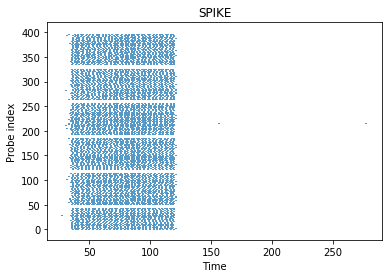

In [17]:
p = exSpikeProbe.plot()

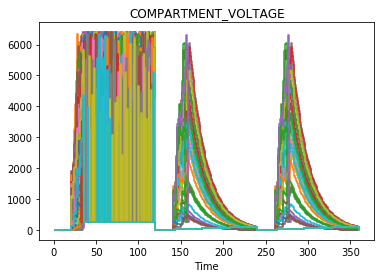

In [12]:
p = exVoltProbe.plot()

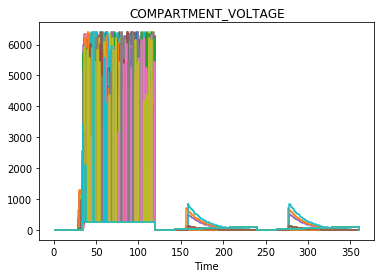

In [13]:
p = inVoltProbe.plot()

In [14]:
print(genInputs)

[[23, 27, 30, 31, 36, 37, 143, 147, 150, 151, 156, 157, 263, 267, 270, 271, 276, 277], [23, 25, 26, 27, 31, 35, 143, 145, 146, 147, 151, 155, 263, 265, 266, 267, 271, 275], [20, 23, 25, 32, 34, 37, 38, 140, 143, 145, 152, 154, 157, 158, 260, 263, 265, 272, 274, 277, 278], [22, 27, 32, 142, 147, 152, 262, 267, 272], [20, 26, 30, 31, 34, 35, 36, 38, 140, 146, 150, 151, 154, 155, 156, 158, 260, 266, 270, 271, 274, 275, 276, 278], [24, 26, 29, 30, 37, 39, 144, 146, 149, 150, 157, 159, 264, 266, 269, 270, 277, 279], [28, 32, 39, 148, 152, 159, 268, 272, 279], [20, 25, 27, 31, 32, 140, 145, 147, 151, 152, 260, 265, 267, 271, 272], [23, 24, 26, 33, 38, 143, 144, 146, 153, 158, 263, 264, 266, 273, 278], [20, 25, 27, 30, 34, 37, 140, 145, 147, 150, 154, 157, 260, 265, 267, 270, 274, 277], [23, 25, 28, 31, 143, 145, 148, 151, 263, 265, 268, 271], [20, 24, 30, 34, 35, 140, 144, 150, 154, 155, 260, 264, 270, 274, 275], [38, 158, 278], [20, 30, 34, 140, 150, 154, 260, 270, 274], [25, 29, 36, 145, 1

In [15]:
print(exVoltProbe.data[:20,120:140])

[[ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9

In [16]:
print(exVoltProbe.data[:20,240:260])

[[ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  3  4  5  6  7  8  9